In [46]:
import matplotlib.pyplot as plt

from FinanceData import get_finance_data

# https://www.kaggle.com/code/kellibelcher/jpx-stock-market-analysis-prediction-with-lgbm

In [47]:
colors = [
    "#ef4444",  # 0
    "#f97316",  # 1
    "#f59e0b",  # 2
    "#eab308",  # 3
    "#84cc16",  # 4
    "#22c55e",  # 5
    "#10b981",  # 6
    "#14b8a6",  # 7
    "#06b6d4",  # 8
    "#0ea5e9",  # 9
    "#3b82f6",  # 10
    "#6366f1",  # 11
    "#8b5cf6",  # 12
    "#a855f7",  # 13
    "#d946ef",  # 14
    "#ec4899",  # 15
    "#f43f5e",  # 16
    "#f3f4f6",  # 17
    "#d1d5db",  # 18
    "#6b7280",  # 19
    "#374151",  # 20
    "#111827",  # 21
]


def rgb_to_float(rgb):
    r = int(rgb[1:3], 16) / 255.0
    g = int(rgb[3:5], 16) / 255.0
    b = int(rgb[5:7], 16) / 255.0

    return (r, g, b)


color_pal = list(map(rgb_to_float, colors))


In [64]:
df = get_finance_data("ks11")
df.drop("Date", inplace=True, axis=1)

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-14,2485.179932,2499.429932,2470.600098,2474.649902,2474.649902,730900.0
2022-11-15,2482.760010,2485.199951,2463.649902,2480.330078,2480.330078,617100.0
2022-11-16,2487.000000,2487.000000,2446.790039,2477.449951,2477.449951,657600.0
2022-11-17,2466.500000,2467.389893,2442.899902,2442.899902,2442.899902,914400.0
2022-11-18,2448.129883,2471.870117,2442.870117,2444.479980,2444.479980,589500.0


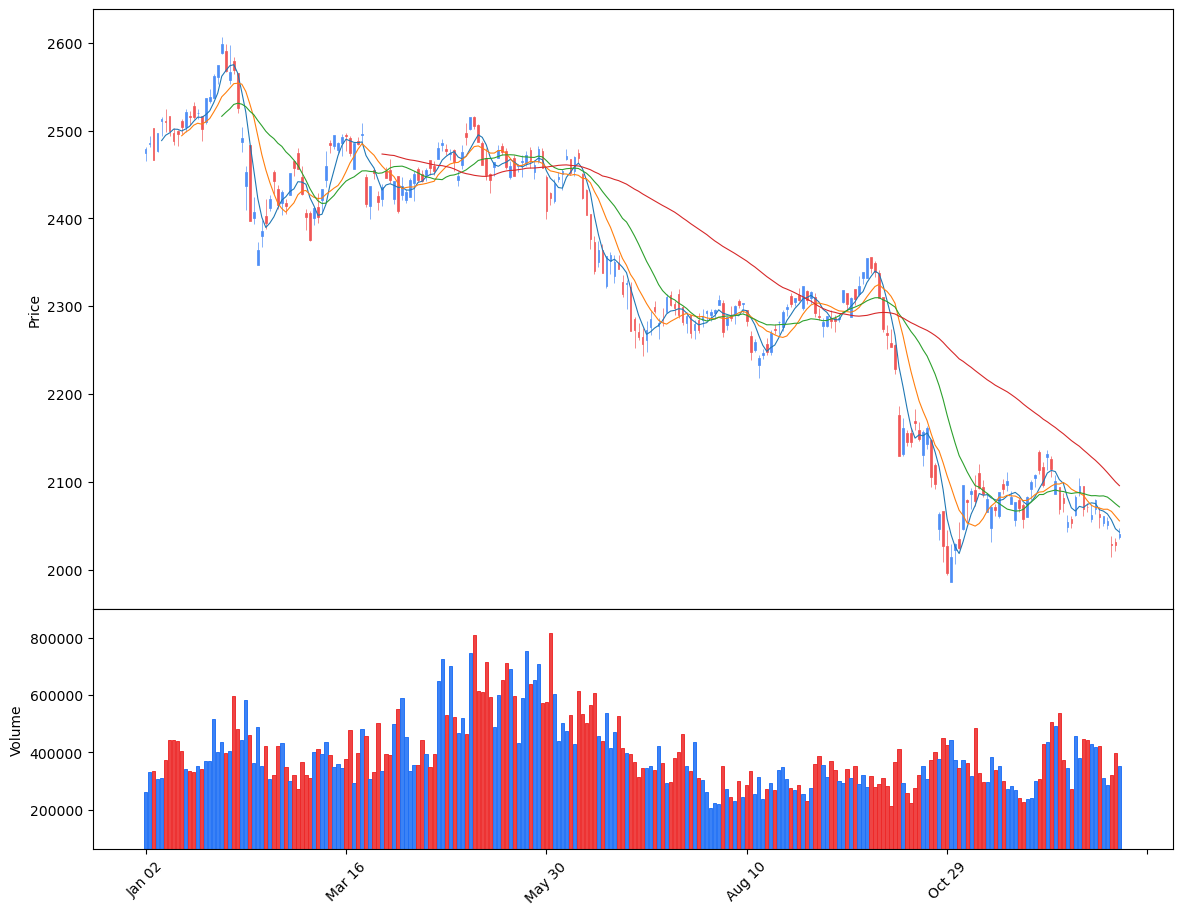

In [49]:
import mplfinance as mpf

one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-30")]

mpf_mc = mpf.make_marketcolors(
    up=colors[10],
    down=colors[0],
    inherit=True
)

mpf_style = mpf.make_mpf_style(marketcolors=mpf_mc)

mpf.plot(one_year_df, type="candle", style=mpf_style, mav=(5, 10, 20, 60), volume=True, figsize=(15, 12))

In [59]:
def rsi(df, n=14):
    close = df["Close"]
    delta = close.diff()[1:]
    
    prices_up = delta.copy()
    prices_down = delta.copy()
    
    prices_up[prices_up < 0] = 0
    prices_down[prices_down > 0] = 0
    
    roll_up = prices_up.rolling(n).mean()
    roll_down = prices_down.abs().rolling(n).mean()
    
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [63]:
import pandas as pd

def create_features(df):
    df = df.drop(columns=["Open", "High", "Low", "Adj Close"])
    
    df["EMA_9"] = df["Close"].ewm(9).mean().shift()
    
    sma_periods = [5, 10, 20, 30, 60]
    
    for period in sma_periods:
        df[f"SMA_{period}"] = df["Close"].rolling(period).mean().shift()
        
    df["RSI"] = rsi(df).fillna(0)

    EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

    df["MACD"] = pd.Series(EMA_12 - EMA_26)
    df["MACD_signal"] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    
    df = df.loc[df.index >= "2001-01-01"]
    
    return df

In [65]:
df = create_features(df)

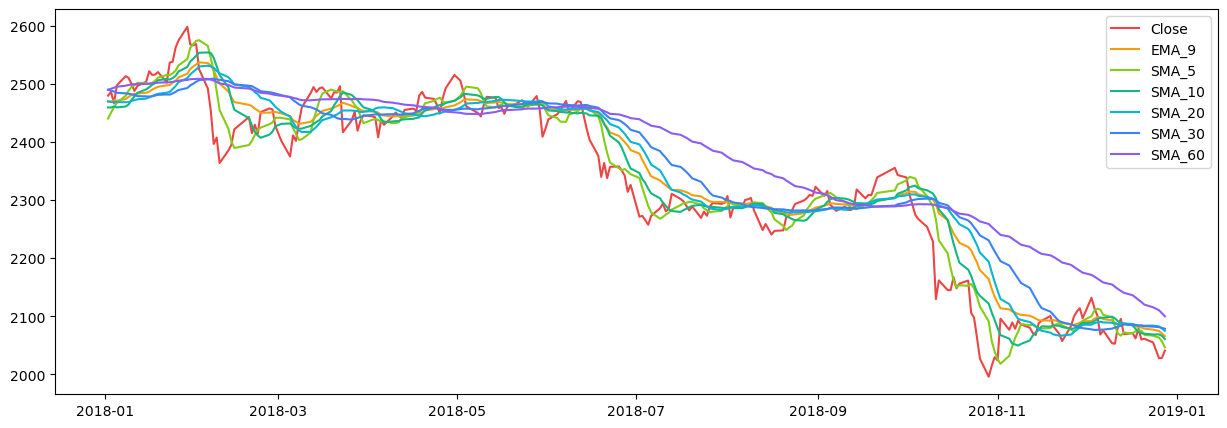

In [71]:
one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

plt.plot(one_year_df["Close"], color=color_pal[0], label="Close")
plt.plot(one_year_df["EMA_9"], color=color_pal[2], label="EMA_9")
plt.plot(one_year_df["SMA_5"], color=color_pal[4], label="SMA_5")
plt.plot(one_year_df["SMA_10"], color=color_pal[6], label="SMA_10")
plt.plot(one_year_df["SMA_20"], color=color_pal[8], label="SMA_20")
plt.plot(one_year_df["SMA_30"], color=color_pal[10], label="SMA_30")
plt.plot(one_year_df["SMA_60"], color=color_pal[12], label="SMA_60")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

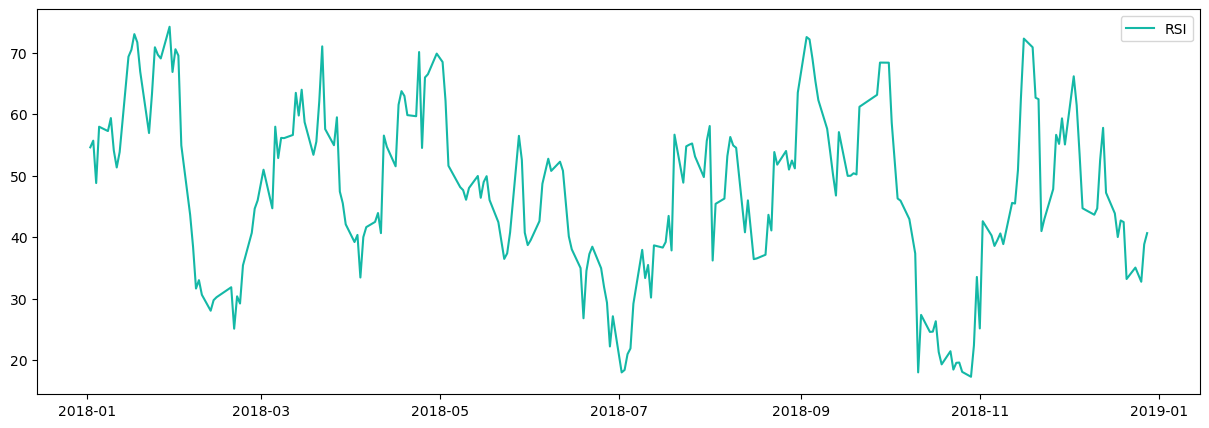

In [72]:
plt.plot(one_year_df["RSI"], color=color_pal[7], label="RSI")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

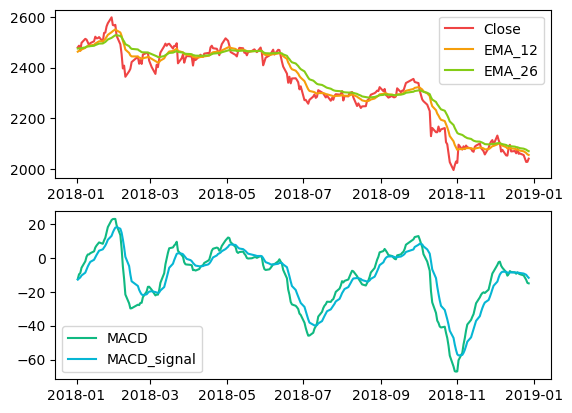

In [77]:
EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

one_year_EMA_12 = EMA_12.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]
one_year_EMA_26 = EMA_26.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

fix, axs = plt.subplots(2)

axs[0].plot(one_year_df["Close"], color=color_pal[0], label="Close")
axs[0].plot(one_year_EMA_12, color=color_pal[2], label="EMA_12")
axs[0].plot(one_year_EMA_26, color=color_pal[4], label="EMA_26")
axs[0].legend()

axs[1].plot(one_year_df["MACD"], color=color_pal[6], label="MACD")
axs[1].plot(one_year_df["MACD_signal"], color=color_pal[8], label="MACD_signal")
axs[1].legend()

fig.set_size_inches(20, 10, forward=True)

In [78]:
train_df = df.loc[df.index < "2018-01-01"].copy()
valid_df = df.loc[("2018-01-01" <= df.index) & (df.index < "2019-07-01")].copy()
test_df = df.loc[("2019-07-01" <= df.index) & (df.index < "2021-01-01")].copy()

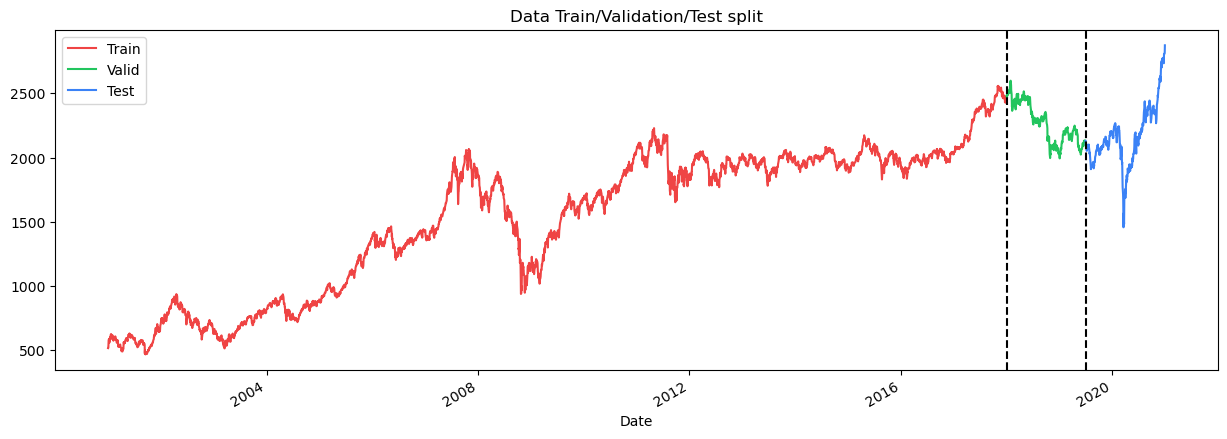

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.Close.plot(ax=ax, color=color_pal[0], label="Train", title="Data Train/Validation/Test split")
valid_df.Close.plot(ax=ax, color=color_pal[5], label="Valid")
test_df.Close.plot(ax=ax, color=color_pal[10], label="Test")
ax.axvline("2018-01-01", color="black", ls="--")
ax.axvline("2019-07-01", color="black", ls="--")
plt.legend()
plt.show()

In [80]:
y_train = train_df["Close"].copy()
X_train = train_df.drop(["Close"], axis=1)

y_valid = valid_df["Close"].copy()
X_valid = valid_df.drop(["Close"], axis=1)

y_test = test_df["Close"].copy()
X_test = test_df.drop(["Close"], axis=1)

In [81]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

In [82]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GroupKFold
import numpy as np

param = {
    "force_col_wise": "true",
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "min_data_in_leaf": 40,
    "tree_learner": "serial",
    "device_type": "cpu",
    "seed": 100,
    "max_depth": 10,
    "metric": "l2",
    "verbose": 0
}

tss = TimeSeriesSplit(5)
folds = tss.split(X_train)
cv_res_gen = lgb.cv(param, lgb_train, num_boost_round=500, folds=folds, callbacks=[lgb.log_evaluation(10000), lgb.early_stopping(30)])
cv_res_obj = lgb.cv(param, lgb_train, num_boost_round=500, folds=tss, callbacks=[lgb.log_evaluation(10000), lgb.early_stopping(30)])

np.testing.assert_allclose(cv_res_gen['l2-mean'], cv_res_obj['l2-mean'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [23]:
param = {
    "force_col_wise": "true",
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 144,
    "tree_learner": "serial",
    "device_type": "cpu",
    "seed": 100,
    "max_depth": 16,
    "metric": "l2",
    "verbose": 0
}

model = lgb.train(param, lgb_train, 1000, lgb_valid, callbacks=[lgb.early_stopping(100)])

Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [24]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

print(f"MSE: {mse}, R2 Score: {r2}")

MSE: 4548.340830742441, R2 Score: 0.9203975441609957


In [26]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis=1)
final_result.columns = ['Label', 'Predict']
final_result.index = y_test.index

final_result

,Label,Predict
Date,,
2019-07-01,2129.739990,2141.829324
2019-07-02,2122.020020,2126.577475
2019-07-03,2096.020020,2107.983636
2019-07-04,2108.729980,2125.363772
2019-07-05,2110.590088,2125.061884
...,...,...
2020-12-23,2759.820068,2532.924872
2020-12-24,2806.860107,2534.496862
2020-12-28,2808.600098,2532.710425


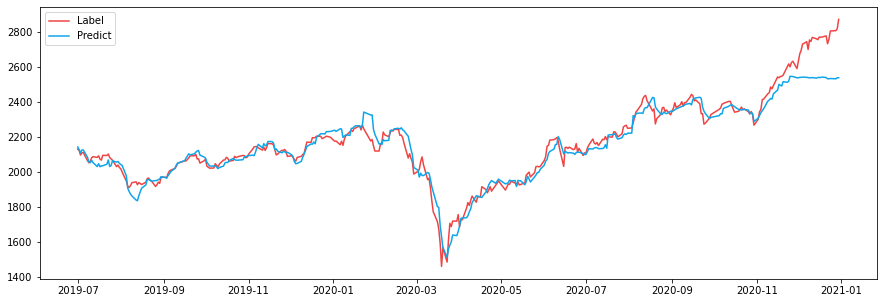

In [27]:
plt.plot(final_result["Label"], color=color_pal[0], label="Label")
plt.plot(final_result["Predict"], color=color_pal[9], label="Predict")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

Use 20 years of data for training, which corresponds to about 5000 trading days(About 252 trading days a year). For each train set, use 5 years of data or 1260 trading days of data and 40 trading days for validation. 